In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataframe train

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving plant_disease.csv to plant_disease.csv


In [3]:
import pandas as pd

plant_disease = pd.read_csv('plant_disease.csv')

plant_disease.head()

,img_path,species_name,is_infected,disease_name
0,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab
1,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab
2,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab
3,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab
4,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab


In [4]:
plant_disease.shape

(70295, 4)

In [5]:
num_classes = len(plant_disease.species_name.unique())
print(num_classes)

14


In [6]:
plant_disease["species_name"] = plant_disease["species_name"].astype(str)

# Dataframe validation

In [7]:
from google.colab import files
data_to_load = files.upload()

Saving df_valid.csv to df_valid.csv


In [8]:
import pandas as pd

df_valid = pd.read_csv('df_valid.csv')

df_valid.head()

,filepath,species_name,is_infected,disease_name
0,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot
1,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot
2,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot
3,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot
4,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot


In [9]:
df_valid["species_name"] = df_valid["species_name"].astype(str)

In [11]:
df_valid.shape

(16973, 4)

# Pré-traitement des données

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import preprocess_input

datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = datagen.flow_from_dataframe(
    dataframe=plant_disease,
    x_col="img_path",
    y_col="species_name",
    target_size=(256, 256),
    batch_size=64,
    subset='training',
    class_mode='categorical'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col="filepath",
    y_col="species_name",
    target_size=(256, 256),
    batch_size=64,
    #subset='validation',
    class_mode='categorical',
    shuffle=False
)

Found 70295 validated image filenames belonging to 14 classes.
Found 16973 validated image filenames belonging to 14 classes.


In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam


# Charger le modèle pré-entraîné (VGG16)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


for layer in vgg16.layers:
    layer.trainable = False

vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [14]:
model = Sequential()
model.add(vgg16)

# Ajouter les couches supplémentaires au modèle

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [15]:
# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Sauvegarde du modèle

model.save('/content/drive/MyDrive/Projet_Reconnaissance_Plantes/5.Modélisation_Deep_learning/Transfer learning/species_name/1.model_tl_vgg16_species_name_full.h5')

In [17]:
from tensorflow.keras import callbacks

# Définir les callbacks
# Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :

checkpoint = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Projet_Reconnaissance_Plantes/5.Modélisation_Deep_learning/Transfer learning/species_name/1.weight_vgg16.h5',
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

# Réduire automatiquement le learning rate
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 5,
                                         factor = 0.5,
                                         verbose = 2,
                                         mode = 'min')

# Arrêter l'entraînement si le modèle n'évolue plus (évite de gérer le nombre d'epoch)

early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                        patience=8,
                                        mode='min',
                                        restore_best_weights=True)

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=25,
    callbacks=[checkpoint, early_stopping, lr_plateau]
)

Epoch 1/25
1098/1098 [==============================] - 16257s 15s/step - loss: 0.1933 - accuracy: 0.9445 - val_loss: 0.0668 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 2/25
1098/1098 [==============================] - 479s 436ms/step - loss: 0.0860 - accuracy: 0.9764 - val_loss: 0.0492 - val_accuracy: 0.9857 - lr: 0.0010
Epoch 3/25
1098/1098 [==============================] - 476s 433ms/step - loss: 0.0627 - accuracy: 0.9832 - val_loss: 0.0405 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 4/25
1098/1098 [==============================] - 481s 438ms/step - loss: 0.0575 - accuracy: 0.9851 - val_loss: 0.0342 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/25
1098/1098 [==============================] - 481s 438ms/step - loss: 0.0424 - accuracy: 0.9885 - val_loss: 0.0307 - val_accuracy: 0.9899 - lr: 0.0010
Epoch 6/25
1098/1098 [==============================] - 485s 442ms/step - loss: 0.0388 - accuracy: 0.9898 - val_loss: 0.0388 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 7/25
1098/1098 [============

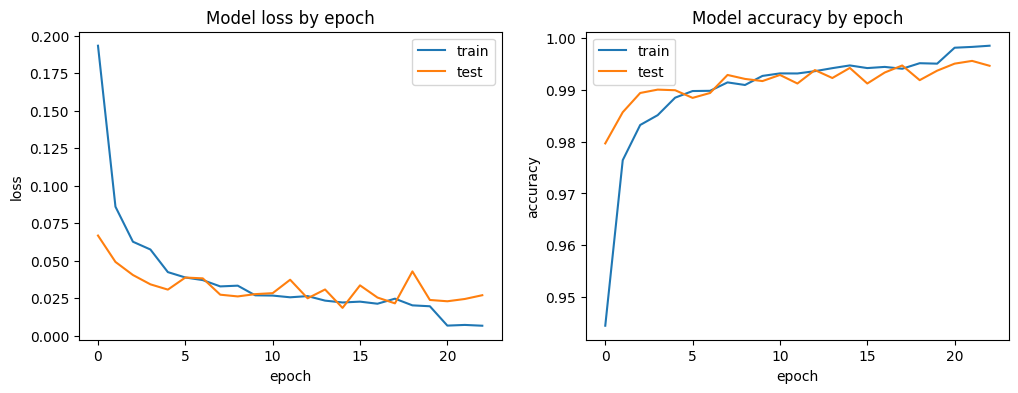

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [21]:
# Sauvegarde du modèle

model.save('/content/drive/MyDrive/Projet_Reconnaissance_Plantes/5.Modélisation_Deep_learning/Transfer learning/species_name/1.modelbis_tl_vgg16_species_name_full.h5')

In [22]:
import numpy as np

predictions = model.predict(valid_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = valid_generator.classes
class_labels = valid_generator.class_indices

266/266 [==============================] - 93s 349ms/step


# Evaluation

In [39]:
import numpy as np
from sklearn.metrics import classification_report

class_labels = list(valid_generator.class_indices.keys())

# Afficher le rapport de classification
report = classification_report(true_labels, predicted_labels, target_names=class_labels)
print(report)

                         precision    recall  f1-score   support

                  Apple       0.99      0.99      0.99      1943
              Blueberry       0.98      1.00      0.99       454
Cherry_(including_sour)       1.00      1.00      1.00       877
           Corn_(maize)       1.00      1.00      1.00      1269
                  Grape       1.00      1.00      1.00      1805
                 Orange       0.99      1.00      1.00       503
                  Peach       0.99      1.00      0.99       891
           Pepper,_bell       0.99      0.99      0.99       975
                 Potato       0.98      0.99      0.99      1426
              Raspberry       1.00      1.00      1.00       445
                Soybean       0.98      1.00      0.99       505
                 Squash       1.00      1.00      1.00       426
             Strawberry       1.00      1.00      1.00       899
                 Tomato       1.00      0.99      0.99      4555

               accuracy

Accuracy: 99.42%


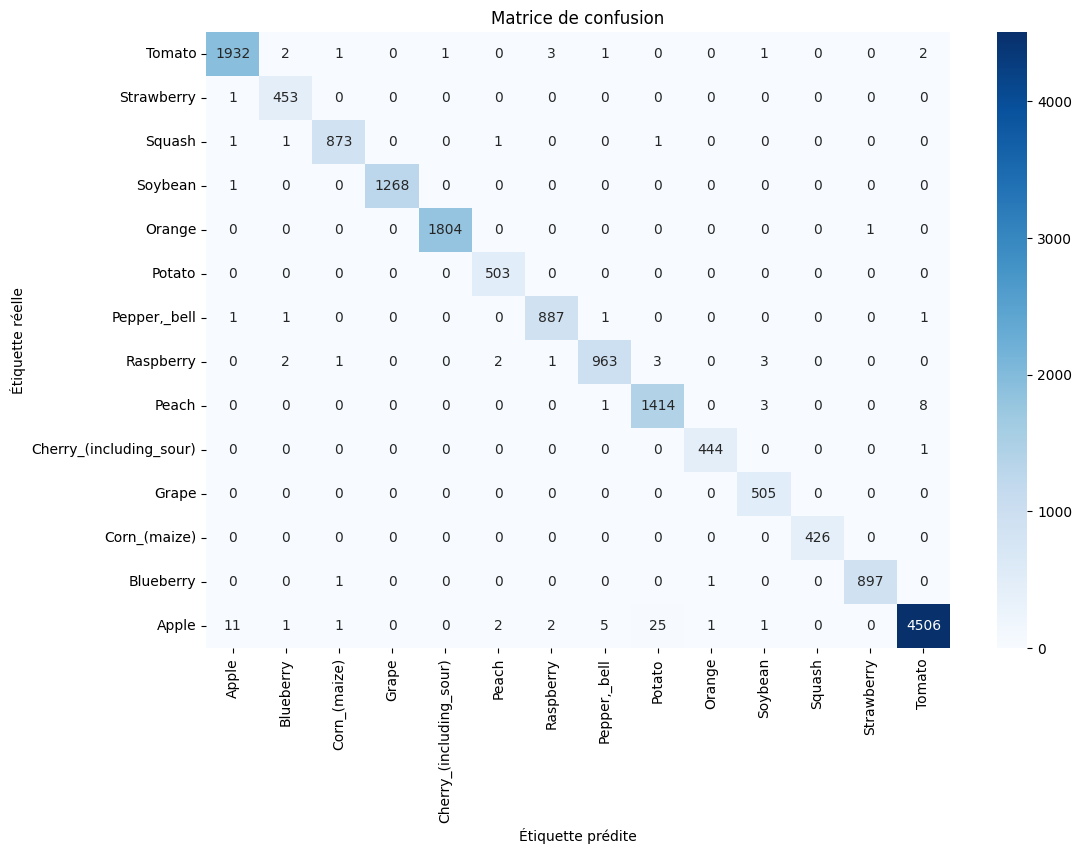

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))

confusion = confusion_matrix(true_labels, predicted_labels)

#class_labels = np.unique(true_labels)
class_labels = df_valid['species_name'].unique()

plt.figure(figsize=(12, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")

# Corriger l'affichage des classes sur les axes
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=90)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels[::-1], rotation=0)

plt.show()

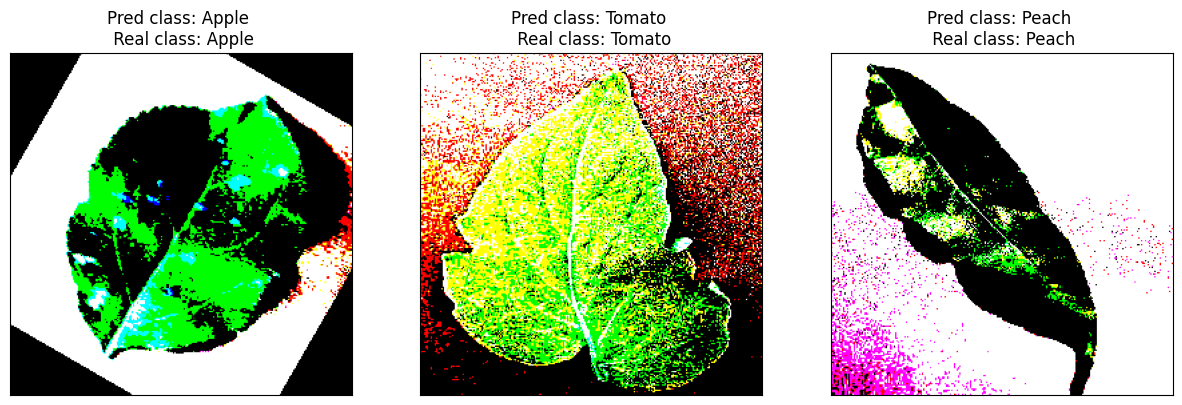

In [37]:
import tensorflow as tf

indices_random = tf.random.uniform([3], 0, len(valid_generator), dtype=tf.int32)

plt.figure(figsize=(15, 7))
for i, idx in enumerate(indices_random):
    # Charger un batch d'images et de prédictions
    batch_images, batch_labels = valid_generator[idx]

    # Sélectionner une image aléatoire dans le batch
    image = batch_images[0]
    pred_class_index = tf.argmax(batch_labels[0])

    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    pred_class = valid_generator.class_indices
    pred_class = dict((v, k) for k, v in pred_class.items())  # Inverser le dictionnaire

    #real_class = pred_generator.classes[idx * pred_generator.batch_size]

    real_class_index = valid_generator.classes[idx * valid_generator.batch_size]
    real_class = pred_class[int(real_class_index)]

    plt.title('Pred class: {} \n Real class: {}'.format(pred_class[int(pred_class_index)], real_class))

plt.show()